# Prediction of the perturbed genes via translation of image-based gene perturbation to regulatory gene embedding

---

This notebook is used to infer a map from the image-based gene perturbation embeddings to the corresponding regulatory gene embeddings in order to enable the out-of-sample prediction of unseen overexpression conditions. To this end, we will make use of the different image-embeddings and morphological profiles obtained from the JUMP data set as well as the regulatory gene embeddings also used in our previous analyses using the data from Rohban et al.

To learn the map we will use the 31 OE conditions that are the subset of the 41 OE conditions from the Rohban data set that we had identified as impacting the chromatin organization which are also covered by the JUMP data set. We will then evaluate the performance of our translation by aiming to predict up to 144 additional OE conditions.

This validation task is actually significantly more difficult than the leave-one-target-out cross-validation setup described in the paper. This is because a) we have substantially less training than test conditions, b) the gene targets of the test conditions tend to be related to pathways not (well) represented among the training conditions, c) the JUMP data shows strong batch effects which dominate the used embedding structures or whose removal seems to reduce the biological signal in the embeddings required to group OE conditions by common effects on the chromatin organization.

To address those challenges, we will employ to strategies:
- To assess how much the imbalance of the training and test conditions affects the performance, we will use the identified clusters of the regulatory gene embeddings and assess the prediction performance for each cluster individually.
- To address the issue of the different batch effects, we will assess the prediction performance using not only the global but also the batch-wise means of the condition-specific embeddings as input to learn the translation. Additionally, we aim to introduce some invariance of the map to the individual batch information by adding these as an additional input features when learning the map.

The performance of all configurations and input gene perturbation embeddings is measured in terms of the kNN accuracy. In particular, the overall procedure will look as follows:
1. Given the image embeddings of the cells in the 175 OE conditions, we will obtain the corresponding gene perturbation embeddings as the condition-wise mean of these embeddings.
2. We will select the 31 OE conditions which are the subset of the 41 impactful gene perturbation settings from the Rohban et al. (2017) data set that are part of the selected 175 conditions of the JUMP data set.
3. We will learn a NTK-based map as described in our paper using these 31 condition that given a image-based gene perturbation embedding predicts the corresponding regulatory gene embedding.
4. Using the learned map, we will obtain predictions of the regulatory gene embeddings for the perturbed gene targets of the remaining 144/175 OE conditions in our data set.
5. Finally, we evaluate the prediction performance for those 144 OE conditions using the k-nearest neighbor accuracy and compare those against a baseline that is equivalent to random chance as described in the paper.

---

## Environmental setup

First, we load in all required software packages and define the required functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import copy
from torch import nn
from torch.optim import Adam
import sys
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import matplotlib as mpl
from sklearn.preprocessing import normalize
import os
import rff
import pickle
import traceback
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.kernel_ridge import KernelRidge

sys.path.append("../../..")

from src.utils.notebooks.translation.analysis import *
from src.data.datasets import IndexedTensorDataset
from src.utils.basic.io import get_genesets_from_gmt_file, get_file_list

mpl.rcParams["figure.dpi"] = 300


seed = 1234

device = "cuda:0"

In [2]:
def label_point(
    x, y, val, ax, reg_size=10, highlight_size=10, highlight=None, highlight_other=None
):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for i in range(len(x)):
        if highlight is not None and val[i] == highlight:
            c = "r"
            weight = "bold"
            size = highlight_size
        elif highlight_other is not None and val[i] in highlight_other:
            c = "b"
            weight = "bold"
        else:
            c = "k"
            weight = "normal"
            size = reg_size
        if x[i] > xmin and x[i] < xmax and y[i] > ymin and y[i] < ymax:
            ax.text(x[i] + 0.02, y[i], val[i], {"size": size, "c": c, "weight": weight})

In [3]:
class SyntheticInterventionModel:
    def __init__(self):
        super().__init__()
        self.alpha = None
        self.X_train = None
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return self

    def predict(self, X_test):
        self.alpha = np.matmul(X_test, np.linalg.pinv(self.X_train))
        y_test = np.matmul(self.alpha, self.Y_train)
        return y_test

In [4]:
class MeanModel:
    def __init__(self):
        super().__init__()
        self.Y_mean = None

    def fit(self, X_train, Y_train):
        self.Y_mean = Y_train
        return self

    def predict(self, X_test=None):
        return np.repeat(self.Y_mean, len(X_test), axis=0)

In [5]:
class RandomModel:
    def __init__(self):
        super().__init__()
        self.Y_train = None

    def fit(self, X_train, Y_train):
        self.Y_train = Y_train
        return self

    def predict(self, X_test=None):
        test_idc = np.random.randint(0, len(self.Y_train), size=len(X_test))
        Y_test = self.Y_train[test_idc]
        return Y_test

In [6]:
def compute_area_under_the_knn_curve(knn_acc_results, max_k=51):
    knn_accs = knn_acc_results.loc[knn_acc_results.k < max_k + 1, "knn_acc"]
    return np.sum(knn_accs) / max_k

In [7]:
def get_jump_knn_hit_data(nn_dict):
    idc = []
    hits = []
    for (k, v) in nn_dict:
        idc.append(k)
        hits.append(np.where(v == k)[0])
    hit_results = pd.DataFrame(np.array(hits), columns=["knn_hit"], index=idc)
    return hit_results

In [8]:
def get_knn_hit_data(nn_dict):
    idc = []
    hits = []
    for k, v in nn_dict.items():
        idc.append(k)
        hits.append(np.where(v == k)[0])
    hit_results = pd.DataFrame(np.array(hits), columns=["knn_hit"], index=idc)
    return hit_results

In [9]:
from numpy.linalg import solve


class NTK:
    def __init__(self, reg=1):
        super().__init__()
        self.reg = reg
        self.sol = None
        self.Xtrain = None

    def kernel(self, pair1, pair2):

        out = pair1 @ pair2.T + 1
        N1 = np.sum(np.power(pair1, 2), axis=-1).reshape(-1, 1) + 1
        N2 = np.sum(np.power(pair2, 2), axis=-1).reshape(-1, 1) + 1

        XX = np.sqrt(N1 @ N2.T)
        out = out / XX

        out = np.clip(out, -1, 1)

        first = (
            1
            / np.pi
            * (out * (np.pi - np.arccos(out)) + np.sqrt(1.0 - np.power(out, 2)))
            * XX
        )
        sec = 1 / np.pi * out * (np.pi - np.arccos(out)) * XX
        out = first + sec

        C = 1
        return out / C

    def fit(self, Xtrain, ytrain):
        K = self.kernel(Xtrain, Xtrain)
        sol = solve(K + self.reg * np.eye(len(K)), ytrain).T
        self.sol = sol
        self.Xtrain = Xtrain
        return self

    def predict(self, X):
        K = self.kernel(self.Xtrain, X)
        return (self.sol @ K).T

In [10]:
def get_jump_input_and_target_features(
    X_train,
    Y_train,
    X_test,
    use_y_train_mean=False,
    use_y_mean=False,
    Y_train_mean=None,
    Y_mean=None,
    Y_all=None,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding="positional",
    append_neighbor_embs=None,
    rff_sigma=1,
    cache_dir=None,
    use_batch_labels=False,
    train_batch_labels=None,
    test_batch_labels=None,
):
    pert_train_samples = list(X_train.index)
    test_target = list(X_test.index)[0]
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)

    if use_batch_labels:
        ohe = OneHotEncoder()
        encoded_batch_labels = ohe.fit_transform(
            np.concatenate([train_batch_labels, test_batch_labels], axis=-1).reshape(
                -1, 1
            )
        ).toarray()
        encoded_train_batch_labels = encoded_batch_labels[: len(train_batch_labels)]
        encoded_test_batch_labels = encoded_batch_labels[len(train_batch_labels) :]
        X_train = np.concatenate([X_train, encoded_train_batch_labels], axis=-1)
        X_test = np.concatenate([X_test, encoded_test_batch_labels], axis=-1)

    if use_y_train_mean and Y_train_mean is not None:
        Y_train_mean = np.array(Y_train_mean).reshape(1, -1)
        X_train = np.concatenate(
            [X_train, np.repeat(Y_train_mean, len(X_train), axis=0)], axis=-1
        )
        X_test = np.concatenate(
            [X_test, np.repeat(Y_train_mean, len(X_test), axis=0)],
            axis=-1,
        )
    if use_y_mean and Y_mean is not None:
        Y_mean = np.array(Y_mean).reshape(1, -1)
        X_train = np.concatenate(
            [X_train, np.repeat(Y_mean, len(X_train), axis=0)], axis=-1
        )
        X_test = np.concatenate(
            [X_test, np.repeat(Y_mean, len(X_test), axis=0)],
            axis=-1,
        )

    ## Use Random Fourier Features of nearest neighbors of the training image embeddings
    if n_neighbors_weights_features > 0:
        nn = NearestNeighbors(n_neighbors=n_neighbors_weights_features)
        nn = nn.fit(X_train)
        X_train_and_test = np.concatenate([X_train, X_test], axis=0)
        neighbors_idcs = nn.kneighbors(X_train_and_test, return_distance=False)

        # Use cached SI coefficients if those are available to redce run-time
        # If the file does not exist but a cache directory is given - the SI coefficients are cached.
        try:
            filehandler = open(
                os.path.join(
                    cache_dir,
                    "neighbor_weights_{}_{}.pkl".format(
                        test_target, n_neighbors_weights_features
                    ),
                ),
                "rb",
            )
            neighbor_weights = pickle.load(filehandler)
            filehandler.close()
        except Exception:
            neighbor_weights = []
            for i in range(len(X_train_and_test)):
                neighbors_idc = neighbors_idcs[i]
                neighbors = X_train[neighbors_idc]
                neighbor_weight = np.matmul(
                    X_train_and_test[i], np.linalg.pinv(neighbors)
                )
                neighbor_weights.append(neighbor_weight)
            neighbors_weights = np.array(neighbor_weights)

            if cache_dir is not None:
                os.makedirs(cache_dir, exist_ok=True)
                filehandler = open(
                    os.path.join(
                        cache_dir,
                        "neighbor_weights_{}_{}.pkl".format(
                            test_target, n_neighbors_weights_features
                        ),
                    ),
                    "wb",
                )
                pickle.dump(neighbor_weights, filehandler)
                filehandler.close()

        neighbor_weights = torch.FloatTensor(neighbor_weights)
        if neighbor_weight_encoding == "positional":
            encoding = rff.layers.PositionalEncoding(
                sigma=rff_sigma, m=n_weight_encodings
            )
        elif neighbor_weight_encoding == "gauss":
            encoding = rff.layers.GaussianEncoding(
                sigma=rff_sigma,
                input_size=neighbor_weights.size(-1),
                encoded_size=n_weight_encodings,
            )
        neighbor_weights = encoding(neighbor_weights).cpu().detach().numpy()

        X_train = np.concatenate([X_train, neighbor_weights[: len(X_train)]], axis=-1)
        X_test = np.concatenate([X_test, neighbor_weights[len(X_train) :]], axis=-1)

        # If desired append embeddings of the nearest neighbors (imaging or regulatory) as additional features
        if append_neighbor_embs is not None:
            neighbor_embs = []
            for i in range(len(X_train_and_test)):
                neighbors_idc = neighbors_idcs[i]
                if append_neighbor_embs == "images":
                    neighbors = X_train[neighbors_idc]
                elif append_neighbor_embs == "genes":
                    neighbors = Y_train[neighbors_idc]
                else:
                    raise NotImplementedError
                neighbor_embs.append(neighbors.reshape(-1))
            neighbor_embs = np.array(neighbor_embs)
            X_train = np.concatenate([X_train, neighbor_embs[: len(X_train)]], axis=-1)
            X_test = np.concatenate([X_test, neighbor_embs[len(X_train) :]], axis=-1)
    return X_train, Y_train, X_test

In [11]:
def get_jump_prediction_for_model(
    X_train,
    Y_train,
    X_test,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    Y_all=None,
    Y_mean=None,
    Y_train_mean=None,
    use_y_train_mean=False,
    use_y_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    use_batch_labels=False,
    train_batch_labels=None,
    test_batch_labels=None,
    normalize_prediction=False,
):
    start_time = time.time()
    # Get potentially transformed input and target features
    X_train, Y_train, X_test = get_jump_input_and_target_features(
        X_train=X_train,
        Y_train=Y_train,
        X_test=X_test,
        use_y_train_mean=use_y_train_mean,
        use_y_mean=use_y_mean,
        Y_all=Y_all,
        Y_mean=Y_mean,
        Y_train_mean=Y_train_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
        use_batch_labels=use_batch_labels,
        train_batch_labels=train_batch_labels,
        test_batch_labels=test_batch_labels,
    )

    # print("Get features", time.time()-start_time)

    # Initialize model
    if model_type == "synthetic_intervention":
        model = SyntheticInterventionModel()
    elif model_type == "linear_regression":
        model = LinearRegression()
    elif model_type == "kernel_regression":
        if model_params_dict is None:
            model = KernelRidge()
        else:
            model = KernelRidge(**model_params_dict)
    elif model_type == "mean":
        model = MeanModel()
        Y_train = Y_train_mean
    elif model_type == "mean_all":
        model = MeanModel()
        Y_train = Y_mean
    elif model_type == "ntk":
        if model_params_dict is not None:
            model = NTK(**model_params_dict)
        else:
            model = NTK()
    elif model_type == "random":
        model = RandomModel()
        Y_train = np.array(Y_all)
    else:
        if model is not None:
            model = model.fit(X_train, Y_train)
        else:
            raise NotImplementedError

    # Fit model and predict
    model = model.fit(X_train, Y_train)
    Y_test = model.predict(X_test)

    if normalize_prediction:
        Y_test = normalize(Y_test)

    # print("Total time", time.time() - start_time)
    return Y_test

In [12]:
def get_jump_nn_prediction_dict(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type="synthethic_intervention",
    model_params_dict=None,
    raw_reg_embs=None,
    use_y_train_mean=False,
    use_y_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    use_batch_labels=False,
    batch_labels=None,
    model=None,
    permute=False,
    debug=False,
    normalize_prediction=False,
    normalize_inputs=False,
    return_predicted_embeddings=False,
):
    nn_pred_dict = []
    emb_pred_dict = []

    # Randomly permute both embeddings to compute a random baseline
    if permute:
        reg_embs = pd.DataFrame(
            np.random.permutation(np.array(reg_embs)),
            index=reg_embs.index,
            columns=reg_embs.columns,
        )
        pert_embs = pd.DataFrame(
            np.random.permutation(np.array(pert_embs)),
            index=pert_embs.index,
            columns=pert_embs.columns,
        )

    if normalize_inputs:
        pert_embs = pd.DataFrame(
            normalize(pert_embs), index=pert_embs.index, columns=pert_embs.columns
        )

    # Identify genes with both corresponding perturbation and regulatory gene embeddings
    shared_targets = set(reg_embs.index).intersection(pert_embs.index)
    # Focus on the perturbation gene embeddings with corresponding regulatory gene embeddings
    pert_embs = pert_embs.loc[list(shared_targets)]

    # Estimate the NearestNeighbor graph of the regulatory gene embeddings using euclidean distances
    reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
    reg_samples = np.array(list(reg_embs.index))
    reg_nn.fit(np.array(reg_embs))

    # Extract perturbation gene names
    pert_samples = np.array(list(pert_embs.index))

    # Identify the test and train samples as the perturbation gene embeddings of the hold-out gene target
    # and all others respectively
    X_train = pert_embs.loc[train_targets]
    Y_train = reg_embs.loc[train_targets]
    X_train = X_train.sort_index()
    Y_train = Y_train.loc[list(X_train.index)]
    X_test = pert_embs.loc[test_targets]

    if use_batch_labels:
        train_batch_labels = batch_labels.loc[train_targets]
        test_batch_labels = batch_labels.loc[test_targets]
    else:
        train_batch_labels = None
        test_batch_labels = None

    if raw_reg_embs is not None:
        Y_mean = normalize(np.array(raw_reg_embs.mean(axis=0)).reshape(1, -1))
        Y_train_mean = normalize(np.array(Y_train.mean(axis=0)).reshape(1, -1))
    else:
        Y_mean = np.array(reg_embs.mean(axis=0)).reshape(1, -1)
        Y_train_mean = np.array(Y_train.mean(axis=0)).reshape(1, -1)

    # Get the predicted regulatory gene embedding for the hold-out gene target
    Y_test = get_jump_prediction_for_model(
        X_train=X_train,
        Y_train=Y_train,
        X_test=X_test,
        model_type=model_type,
        model_params_dict=model_params_dict,
        Y_mean=Y_mean,
        Y_train_mean=Y_train_mean,
        use_y_train_mean=use_y_train_mean,
        use_y_mean=use_y_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
        use_batch_labels=use_batch_labels,
        train_batch_labels=train_batch_labels,
        test_batch_labels=test_batch_labels,
        model=model,
        Y_all=reg_embs,
        normalize_prediction=normalize_prediction,
    )
    for i in range(len(Y_test)):
        test_target = list(X_test.index)[i]
        y_test = Y_test[i].reshape(1, -1)
        emb_pred_dict.append((test_target, y_test))
        # Identify the sorted nearest neighbor list of the prediction among all regulatory gene embeddings
        reg_nns = reg_samples[reg_nn.kneighbors(y_test, return_distance=False)][0]
        nn_pred_dict.append((test_target, reg_nns))

        if not permute and debug:
            print(
                model_type,
                test_target,
                np.where(reg_nns == test_target)[0],
                reg_nns[:5],
            )
            # print(y_test)

    # Return a dictionary with the key identifying the hold-out gene target and the corresponding value the
    # names of the regulatory gene embeddings closest to the prediction in increasing euclidean distance
    if not return_predicted_embeddings:
        return nn_pred_dict
    else:
        return nn_pred_dict, emb_pred_dict

In [13]:
def get_jump_knn_hits_for_model(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type="synthetic_intervention",
    model=None,
    model_params_dict=None,
    raw_reg_embs=None,
    use_y_train_mean=False,
    use_y_mean=False,
    n_neighbors_weights_features=0,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    n_weight_encodings=10,
    rff_sigma=1,
    use_batch_labels=False,
    batch_labels=None,
    normalize_prediction=False,
    normalize_inputs=False,
):
    # Function to compute the nearest neighbor accuracy for a given set of perturbation and
    # regulatory gene embeddings for a specified model type

    # Get nearest-neighbor prediction dictionary
    nn_dict = get_jump_nn_prediction_dict(
        pert_embs=pert_embs,
        reg_embs=reg_embs,
        train_targets=train_targets,
        test_targets=test_targets,
        model_type=model_type,
        model=model,
        model_params_dict=model_params_dict,
        raw_reg_embs=raw_reg_embs,
        use_y_train_mean=use_y_train_mean,
        use_y_mean=use_y_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
        use_batch_labels=use_batch_labels,
        batch_labels=batch_labels,
        normalize_inputs=normalize_inputs,
        normalize_prediction=normalize_prediction,
        permute=False,
    )
    knn_hit_data = get_jump_knn_hit_data(nn_dict)
    return knn_hit_data

In [14]:
def get_jump_perm_knn_hits_for_model(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    raw_reg_embs=None,
    use_y_train_mean=False,
    use_y_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    use_batch_labels=False,
    batch_labels=None,
    normalize_inputs=False,
    normalize_prediction=False,
    b=500,
    random_state=1234,
):
    # Function that also computes the knn accuracy for a given model/type but randomly permutes the perturbation
    # and regulatory gene embeddings to establish a random baseline

    np.random.seed(random_state)
    all_knn_hit_data = []
    for i in tqdm(range(b)):
        nn_dict = get_jump_nn_prediction_dict(
            pert_embs=pert_embs,
            reg_embs=reg_embs,
            train_targets=train_targets,
            test_targets=test_targets,
            model_type=model_type,
            model_params_dict=model_params_dict,
            raw_reg_embs=raw_reg_embs,
            use_y_train_mean=use_y_train_mean,
            use_y_mean=use_y_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            rff_sigma=rff_sigma,
            use_batch_labels=use_batch_labels,
            batch_labels=batch_labels,
            model=model,
            normalize_inputs=normalize_inputs,
            normalize_prediction=normalize_prediction,
            permute=True,
        )
        knn_hit_data = get_jump_knn_hit_data(nn_dict)
        all_knn_hit_data.append(knn_hit_data)
    return pd.concat(all_knn_hit_data)

In [15]:
def plot_translation_performance(
    results,
    hue,
    ymax,
    title="",
    random_baseline=None,
    mean_baseline=None,
    mean_train_baseline=None,
    figsize=[9, 6],
    cmap=None,
    style=None,
    style_order=None,
    param_title=None,
    legend_title="Model",
    alpha=0.8,
):
    sns.set_style("whitegrid")
    if param_title is None:
        param_title = hue
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.lineplot(
        data=results,
        x="k",
        y="knn_acc",
        hue=hue,
        palette=cmap,
        style=style,
        style_order=style_order,
        alpha=alpha,
    )
    if mean_train_baseline is not None:
        ax = sns.lineplot(
            data=mean_train_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Mean baseline (train)",
            color="red",
            legend=False,
            alpha=alpha,
            linestyle="dotted",
        )
    if mean_baseline is not None:
        ax = sns.lineplot(
            data=mean_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Mean baseline",
            color="r",
            linestyle="--",
            legend=False,
            alpha=alpha,
        )
    if random_baseline is not None:
        ax = sns.lineplot(
            data=random_baseline,
            x="k",
            y="knn_acc",
            ax=ax,
            label="Random baseline",
            color="dimgray",
            linestyle="--",
            legend=False,
            alpha=alpha,
        )
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 51, 5))
    ax.set_yticks(np.arange(0, ymax, 0.05))
    ax.legend(title=legend_title, loc="upper left", frameon=True)

    return fig, ax

In [16]:
def get_all_jump_knn_hits_for_model(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    config_id=None,
    model_type="synthetic_intervention",
    model_params_dict=None,
    model=None,
    raw_reg_embs=None,
    use_y_train_mean=False,
    use_y_mean=False,
    n_neighbors_weights_features=0,
    n_weight_encodings=10,
    neighbor_weight_encoding=None,
    append_neighbor_embs=None,
    rff_sigma=1,
    use_batch_labels=False,
    batch_labels=None,
    normalize_prediction=False,
    normalize_inputs=False,
    b=50,
    n_clusters=5,
    auc_ks=[6, 11, 16, 21, 26, 31, 51],
):
    knn_hits_results = get_jump_knn_hits_for_model(
        pert_embs=pert_embs,
        reg_embs=reg_embs,
        train_targets=train_targets,
        test_targets=test_targets,
        model_type=model_type,
        model_params_dict=model_params_dict,
        model=model,
        raw_reg_embs=raw_reg_embs,
        use_y_train_mean=use_y_train_mean,
        use_y_mean=use_y_mean,
        n_neighbors_weights_features=n_neighbors_weights_features,
        n_weight_encodings=n_weight_encodings,
        neighbor_weight_encoding=neighbor_weight_encoding,
        append_neighbor_embs=append_neighbor_embs,
        rff_sigma=rff_sigma,
        use_batch_labels=use_batch_labels,
        batch_labels=batch_labels,
        normalize_inputs=normalize_inputs,
        normalize_prediction=normalize_prediction,
    )
    knn_hits_results["model"] = model_type
    for k, v in model_params_dict.items():
        knn_hits_results[k] = v
    knn_hits_results["use_mean_train_reg_embs"] = use_y_train_mean
    knn_hits_results["use_mean_reg_embs"] = use_y_mean
    knn_hits_results["n_neighbors_pos_encodings"] = n_neighbors_weights_features
    knn_hits_results["n_pos_encodings"] = n_weight_encodings
    knn_hits_results["pos_encoding_type"] = neighbor_weight_encoding
    knn_hits_results["append_neighbor_embs"] = append_neighbor_embs
    knn_hits_results["rff_sigma"] = rff_sigma
    knn_hits_results["use_batch_labels"] = use_batch_labels
    knn_hits_results["normalize_inputs"] = normalize_inputs
    knn_hits_results["normalize_prediction"] = normalize_prediction
    knn_hits_results["config_id"] = config_id

    if b > 0:
        perm_knn_hits_results = get_jump_perm_knn_hits_for_model(
            pert_embs=pert_embs,
            reg_embs=reg_embs,
            train_targets=train_targets,
            test_targets=test_targets,
            model_type=model_type,
            model_param_dict=model_param_dict,
            model=model,
            raw_reg_embs=raw_reg_embs,
            use_y_train_mean=use_y_train_mean,
            use_y_mean=use_y_mean,
            n_neighbors_weights_features=n_neighbors_weights_features,
            n_weight_encodings=n_weight_encodings,
            neighbor_weight_encoding=neighbor_weight_encoding,
            append_neighbor_embs=append_neighbor_embs,
            use_batch_labels=use_batch_labels,
            batch_labels=batch_labels,
            normalize_prediction=normalize_prediction,
            normalize_inputs=normalize_inputs,
            b=b,
        )
        perm_knn_hits_results["model"] = model_type
        for k, v in model_params_dict.items():
            perm_knn_hits_results[k] = v
        perm_knn_hits_results["use_mean_train_reg_embs"] = use_y_train_mean
        perm_knn_hits_results["use_mean_reg_embs"] = use_y_mean
        perm_knn_hits_results[
            "n_neighbors_pos_encodings"
        ] = n_neighbors_weights_features
        perm_knn_hits_results["n_pos_encodings"] = n_weight_encodings
        perm_knn_hits_results["pos_encoding_type"] = neighbor_weight_encoding
        perm_knn_hits_results["append_neighbor_embs"] = append_neighbor_embs
        perm_knn_hits_results["rff_sigma"] = rff_sigma
        perm_knn_hits_results["use_batch_labels"] = use_batch_labels
        perm_knn_hits_results["normalize_inputs"] = normalize_inputs
        perm_knn_hits_results["normalize_predictions"] = normalize_predictions
        perm_knn_hits_results["config_id"] = config_id
    else:
        perm_knn_hits_results = None

    return knn_hits_results, perm_knn_hits_results

In [17]:
def get_all_gridsearch_configs(
    model_params_dicts=[None],
    use_y_train_mean_params=[False],
    use_y_mean_params=[False],
    n_neighbors_weights_features_params=[0],
    n_weight_encodings_params=[0],
    append_neighbor_embs_params=[False],
    neighbor_weight_encoding_params=[None],
    rff_sigma_params=[1],
    use_batch_labels_params=[True],
    normalize_prediction_params=[False],
    normalize_inputs_params=[False],
    batch_labels=None,
    save_output_file=None,
):
    all_knn_hit_results = []
    config_id = 0

    model_params_df = pd.DataFrame(
        np.array(model_params_dicts).astype(object), columns=["model_params_dict"]
    )
    use_y_train_mean_df = pd.DataFrame(
        use_y_train_mean_params, columns=["use_y_train_mean"]
    )
    use_y_mean_df = pd.DataFrame(use_y_mean_params, columns=["use_y_mean"])
    n_neighbors_weights_features_params_df = pd.DataFrame(
        n_neighbors_weights_features_params, columns=["n_neighbors_weights_features"]
    )
    n_weight_encodings_params_df = pd.DataFrame(
        n_weight_encodings_params, columns=["n_weight_encodings"]
    )
    append_neighbor_embs_params_df = pd.DataFrame(
        append_neighbor_embs_params, columns=["append_neighbor_embs"]
    )
    neighbor_weight_encoding_params_df = pd.DataFrame(
        neighbor_weight_encoding_params, columns=["neighbor_weight_encoding"]
    )
    rff_sigma_params_df = pd.DataFrame(rff_sigma_params, columns=["rff_sigma"])
    use_batch_labels_params_df = pd.DataFrame(
        use_batch_labels_params, columns=["use_batch_labels"]
    )
    normalize_prediction_params_df = pd.DataFrame(
        normalize_prediction_params, columns=["normalize_prediction"]
    )
    normalize_inputs_params_df = pd.DataFrame(
        normalize_inputs_params, columns=["normalize_inputs"]
    )

    config_dfs = [
        model_params_df,
        use_y_train_mean_df,
        use_y_mean_df,
        n_neighbors_weights_features_params_df,
        n_weight_encodings_params_df,
        append_neighbor_embs_params_df,
        neighbor_weight_encoding_params_df,
        rff_sigma_params_df,
        use_batch_labels_params_df,
        normalize_prediction_params_df,
        normalize_inputs_params_df,
    ]

    all_configs_df = None
    for config_df in config_dfs:
        if all_configs_df is None:
            all_configs_df = config_df
        else:
            all_configs_df = all_configs_df.merge(config_df, how="cross")

    # Filter out artifact configurations
    all_configs_df = all_configs_df.loc[
        (all_configs_df.n_neighbors_weights_features == 0)
        | (all_configs_df.n_neighbors_weights_features == 31)
        | (all_configs_df.append_neighbor_embs.notnull())
    ]
    return all_configs_df

In [18]:
def run_jump_gridsearch_knn_hits(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    model_type,
    model=None,
    raw_reg_embs=None,
    model_params_dicts=[None],
    use_y_train_mean_params=[False],
    use_y_mean_params=[False],
    n_neighbors_weights_features_params=[0],
    n_weight_encodings_params=[0],
    append_neighbor_embs_params=[False],
    neighbor_weight_encoding_params=[None],
    rff_sigma_params=[1],
    use_batch_labels_params=[True],
    normalize_prediction_params=[False],
    normalize_inputs_params=[False],
    batch_labels=None,
    save_output_file=None,
):
    all_knn_hit_results = []
    config_id = 0

    all_configs = get_all_gridsearch_configs(
        model_params_dicts=model_params_dicts,
        use_y_train_mean_params=use_y_train_mean_params,
        use_y_mean_params=use_y_mean_params,
        n_neighbors_weights_features_params=n_neighbors_weights_features_params,
        n_weight_encodings_params=n_weight_encodings_params,
        append_neighbor_embs_params=append_neighbor_embs_params,
        neighbor_weight_encoding_params=neighbor_weight_encoding_params,
        rff_sigma_params=rff_sigma_params,
        use_batch_labels_params=use_batch_labels_params,
        normalize_prediction_params=normalize_prediction_params,
        normalize_inputs_params=normalize_inputs_params,
    )

    for _, row in tqdm(all_configs.iterrows(), total=all_configs.shape[0]):
        try:
            knn_hit_results, _, = get_all_jump_knn_hits_for_model(
                pert_embs=pert_embs,
                reg_embs=reg_embs,
                train_targets=train_targets,
                test_targets=test_targets,
                config_id=config_id,
                model_type=model_type,
                raw_reg_embs=raw_reg_embs,
                model_params_dict=row["model_params_dict"],
                model=model,
                use_y_train_mean=row["use_y_train_mean"],
                use_y_mean=row["use_y_mean"],
                n_neighbors_weights_features=row["n_neighbors_weights_features"],
                n_weight_encodings=row["n_weight_encodings"],
                append_neighbor_embs=row["append_neighbor_embs"],
                neighbor_weight_encoding=row["neighbor_weight_encoding"],
                rff_sigma=row["rff_sigma"],
                use_batch_labels=row["use_batch_labels"],
                normalize_prediction=row["normalize_prediction"],
                normalize_inputs=row["normalize_inputs"],
                batch_labels=batch_labels,
                b=0,
                n_clusters=None,
            )
            all_knn_hit_results.append(knn_hit_results.copy())
            config_id += 1
        except IndexError:
            traceback.print_exc()
            continue

    all_knn_hit_results = pd.concat(all_knn_hit_results)
    if save_output_file is not None:
        os.makedirs(os.path.split(save_output_file)[0], exist_ok=True)
        all_knn_hit_results.to_hdf(save_output_file, key="data", index=False)
    return all_knn_hit_results

In [19]:
def output_best_model_config_ids(
    results, metric_cols, config_id_col="config_id", n_config_ids=1
):
    opt_metrics_dict = {"config_id": [], "metric": [], "value": []}
    grouped = results.groupby(config_id_col).mean(numeric_only=True)
    for metric_col in metric_cols:
        opt_results = grouped.sort_values(metric_col, ascending=False).iloc[
            :n_config_ids
        ]

        opt_config_ids = list(opt_results.index)
        opt_metrics = list(np.round(opt_results.loc[:, metric_col], 6))

        opt_metrics_dict["config_id"].extend(opt_config_ids)
        opt_metrics_dict["value"].extend(opt_metrics)
        opt_metrics_dict["metric"].extend([metric_col] * len(opt_config_ids))

    opt_metrics_df = pd.DataFrame(opt_metrics_dict)
    duplicate_config_ids = []
    for k, v in Counter(opt_metrics_df.config_id).items():
        if v >= 2:
            duplicate_config_ids.append(k)
    return opt_metrics_df.loc[opt_metrics_df.config_id.isin(duplicate_config_ids)]

In [20]:
def get_jump_random_nn_prediction_dict(
    pert_embs, reg_embs, train_targets, test_targets, random_state=1234
):
    nn_pred_dict = []
    # Estimate the NearestNeighbor graph of the regulatory gene embeddings using euclidean distances
    reg_nn = NearestNeighbors(n_neighbors=len(reg_embs))
    reg_samples = np.array(list(reg_embs.index))
    reg_nn.fit(np.array(reg_embs))

    for test_target in test_targets:
        y_test_idc = np.random.choice(list(reg_embs.index))
        y_test = np.array(reg_embs.loc[y_test_idc]).reshape(1, -1)
        # Identify the sorted nearest neighbor list of the prediction among all regulatory gene embeddings
        reg_nns = reg_samples[reg_nn.kneighbors(y_test, return_distance=False)][0]
        nn_pred_dict.append((test_target, reg_nns))

    # Return a dictionary with the key identifying the hold-out gene target and the corresponding value the
    # names of the regulatory gene embeddings closest to the prediction in increasing euclidean distance
    return nn_pred_dict

In [21]:
def get_knn_accs_for_config_ids(perf_data, cluster_data, train_targets, max_k=51):
    covered_clusters = list(np.unique(cluster_data.loc[train_targets]))
    perf_data["cluster"] = np.array(cluster_data.loc[perf_data.index])
    result = {
        "config_id": [],
        "cluster": [],
        "genes": [],
        "knn_hits": [],
        "k": [],
        "knn_acc": [],
    }
    for config_id in tqdm(set(perf_data.config_id)):
        entry = perf_data.loc[perf_data.config_id == config_id]
        for cluster in list(set(entry.cluster)) + ["covered_clusters", "all"]:
            if cluster == "covered_clusters":
                cluster_entry = entry.loc[entry.cluster.isin(covered_clusters)]
            elif cluster == "all":
                cluster_entry = entry.loc[entry.cluster.isin(list(set(entry.cluster)))]
            else:
                cluster_entry = entry.loc[entry.cluster == cluster]
            for k in range(1, max_k):
                result["config_id"].append(config_id)
                result["cluster"].append(cluster)
                result["k"].append(k)
                result["genes"].append(list(cluster_entry.index))
                result["knn_hits"].append(list(cluster_entry.knn_hit))
                result["knn_acc"].append(np.mean(cluster_entry.knn_hit < k))
    return pd.DataFrame(result)

In [22]:
def get_cluster_knn_accs_for_config_ids(
    perf_data, cluster_data, drop_clusters, max_k=51
):
    perf_data["cluster"] = np.array(cluster_data.loc[perf_data.index])
    result = {
        "config_id": [],
        "cluster": [],
        "genes": [],
        "knn_hits": [],
        "k": [],
        "knn_acc": [],
    }
    for config_id in tqdm(set(perf_data.config_id)):
        entry = perf_data.loc[perf_data.config_id == config_id]
        for drop_cluster in drop_clusters:
            if len(drop_cluster) > 0:
                dropped_clusters = "_".join(np.array(drop_cluster).astype(str))
            else:
                dropped_clusters = ""
            cluster_entry = entry.loc[~entry.cluster.isin(drop_cluster)]
            for k in range(1, max_k):
                result["config_id"].append(config_id)
                result["cluster"].append(dropped_clusters)
                result["k"].append(k)
                result["genes"].append(list(cluster_entry.index))
                result["knn_hits"].append(list(cluster_entry.knn_hit))
                result["knn_acc"].append(np.mean(cluster_entry.knn_hit < k))
    return pd.DataFrame(result)

In [23]:
def add_cluster_aucs_for_knn_acc_results(knn_acc_results, auc_ks=[10, 20, 30, 40, 50]):
    for auc_k in auc_ks:
        knn_acc_results["{}nn_auc".format(auc_k)] = np.nan
    for config_id in tqdm(set(knn_acc_results.config_id)):
        entry = knn_acc_results.loc[knn_acc_results.config_id == config_id]
        for cluster in set(knn_acc_results.cluster):
            cluster_entry = entry.loc[entry.cluster == cluster]
            for auc_k in auc_ks:
                knn_acc_results.loc[
                    cluster_entry.index, "{}nn_auc".format(auc_k)
                ] = compute_area_under_the_knn_curve(cluster_entry, max_k=auc_k)
    return knn_acc_results

In [24]:
def plot_sample_knn_acc_results(knn_acc_results, n_reg_embs=249):
    for config_id in set(knn_acc_results.config_id):
        fig, ax = plt.subplots(figsize=[10, 8])
        ax.set_xlim(0, 51)
        ax.set_ylim(0, 1.0)
        ax = sns.lineplot(
            data=knn_acc_results.loc[knn_acc_results.config_id == config_id],
            x="k",
            y="knn_acc",
            hue="cluster",
            palette="tab10",
        )
        ax.set_title("Config ID: {}".format(config_id))
        ax.plot(
            list(range(1, 51)),
            [k / n_reg_embs for k in range(1, 51)],
            label="random",
            linestyle="--",
            c="k",
        )
        plt.show()
        plt.close()

In [25]:
def plot_mean_baseline(
    pert_embs,
    reg_embs,
    train_targets,
    test_targets,
    reg_embs_clusters,
    model_type="mean_all",
):
    knn_hit_data = get_jump_knn_hit_data(
        get_jump_nn_prediction_dict(
            pert_embs,
            regulatory_embs,
            list(train_targets),
            list(test_targets),
            model_type=model_type,
        )
    )
    knn_hit_data["config_id"] = 0
    knn_results = get_knn_accs_for_config_ids(knn_hit_data, reg_embs_clusters)
    plot_sample_knn_acc_results(knn_results)

In [26]:
def get_tsne_translation_prediction(
    pert_embs,
    reg_embs,
    target,
    reg_pred,
    perplexity=None,
    random_state=1234,
    init="random",
    metric="euclidean",
):

    reg_embs_w_target = reg_embs.copy()
    if len(reg_pred) == 1:
        reg_embs_w_target.loc["PREDICTION"] = reg_pred.reshape(-1)
    else:
        for i in range(len(reg_pred)):
            reg_embs_w_target = pd.concat(
                [
                    reg_embs_w_target,
                    pd.DataFrame(
                        reg_pred[i].reshape(1, -1),
                        columns=reg_embs_w_target.columns,
                        index=["PREDICTION"],
                    ),
                ]
            )
    #             reg_embs_w_target.loc["PREDICTION_{}".format(i)] = reg_pred[i].reshape(-1)

    if perplexity is None:
        pert_perplexity = np.ceil(np.sqrt(len(pert_embs)))
        reg_perplexity = np.ceil(np.sqrt(len(reg_embs_w_target)))
    else:
        pert_perplexity = reg_perplexity = perplexity

    # Perturbation gene embedding tsne
    tsne_pert = TSNE(
        random_state=random_state,
        n_components=2,
        perplexity=pert_perplexity,
        metric=metric,
        init=init,
    )
    pert_tsne_embs = pd.DataFrame(
        tsne_pert.fit_transform(pert_embs),
        columns=["tsne1", "tsne2"],
        index=pert_embs.index,
    )

    # Regulatory gene embedding tsne
    tsne_reg = TSNE(
        random_state=random_state,
        n_components=2,
        perplexity=reg_perplexity,
        metric=metric,
        init=init,
    )
    reg_tsne_embs = pd.DataFrame(
        tsne_reg.fit_transform(reg_embs_w_target),
        columns=["tsne1", "tsne2"],
        index=reg_embs_w_target.index,
    )
    return pert_tsne_embs, reg_tsne_embs

In [27]:
def get_nearest_neighbors_for_target(
    embs, target, prediction=None, selected_targets=None
):
    if prediction is not None:
        tmp = embs.copy()
        tmp.loc["PREDICTION"] = np.array(prediction).reshape(-1)
        target = "PREDICTION"
    else:
        tmp = embs.copy()

    if selected_targets:
        tmp = tmp.loc[selected_targets]
    samples = np.array(tmp.index)
    nn = NearestNeighbors(n_neighbors=len(tmp))
    nn = nn.fit(tmp)
    knns = nn.kneighbors(
        np.array(tmp.loc[target]).reshape(1, -1), return_distance=False
    )
    return samples[knns]

In [28]:
def plot_translation_tsne(
    embs,
    fig,
    ax,
    target=None,
    prediction=None,
    target_size=20,
    size=15,
    pred_size=20,
    pred_color="r",
    target_color="green",
    color="b",
    lw=1,
    alpha=1,
    marker_lw=2,
    p_alpha=0.7,
    mark_neighbors=None,
    neighbor_size=8,
    label_points=None,
    reg_label_size=12,
):

    exclude = []
    if prediction is not None:
        exclude.append(prediction)
    if target is not None:
        exclude.append(target)
    exclude = list(np.array(exclude).reshape(-1))

    ax.scatter(
        np.array(embs.loc[~embs.index.isin(exclude), "tsne1"]),
        np.array(embs.loc[~embs.index.isin(exclude), "tsne2"]),
        c=color,
        s=size,
        zorder=1,
        alpha=p_alpha,
    )

    if mark_neighbors is not None:
        ax.scatter(
            np.array(embs.loc[mark_neighbors, "tsne1"]),
            np.array(embs.loc[mark_neighbors, "tsne2"]),
            c="k",
            s=neighbor_size,
            zorder=1,
            alpha=1,
            edgecolors="k",
        )

    if target is not None:
        ax.scatter(
            np.array(embs.loc[target, "tsne1"]),
            np.array(embs.loc[target, "tsne2"]),
            c=target_color,
            s=target_size,
            zorder=1,
            alpha=1,
            facecolors=target_color,
            edgecolors=target_color,
        )
    if prediction is not None:
        ax.scatter(
            np.array(embs.loc[prediction, "tsne1"]),
            np.array(embs.loc[prediction, "tsne2"]),
            # c=pred_color,
            s=pred_size,
            zorder=1,
            facecolors="none",
            edgecolors=pred_color,
            linewidth=marker_lw,
            alpha=1,
        )

    if label_points is not None:
        to_label_embs = embs.loc[embs.index.isin(label_points)]
        label_point(
            np.array(to_label_embs.loc[:, "tsne1"]),
            np.array(to_label_embs.loc[:, "tsne2"]),
            np.array(to_label_embs.index).astype("str"),
            ax=ax,
            reg_size=reg_label_size,
        )

    return fig, ax

In [29]:
def get_mean_knn_hit_data(pred_nns, mean_id="MEAN"):
    result = {"gene": [], "knn_hit": []}
    for gene, nns in pred_nns:
        result["gene"].append(gene)
        result["knn_hit"].append(np.where(nns == mean_id)[0])
    return pd.DataFrame(result, index=result["gene"])

In [30]:
def get_mean_hit_fraction(
    pred_nns, train_targets, test_targets, max_k=51, mean_id="MEAN"
):
    mean_knn_hit_data = get_mean_knn_hit_data(pred_nns, mean_id=mean_id)
    result = {"k": [], "rel_knn_hit": [], "target_type": []}
    for k in range(1, max_k):
        for target_type in ["train", "test"]:
            result["k"].append(k)
            result["target_type"].append(target_type)
            if target_type == "train":
                result["rel_knn_hit"].append(
                    np.mean(mean_knn_hit_data.loc[train_targets, "knn_hit"] < k)
                )
            else:
                result["rel_knn_hit"].append(
                    np.mean(mean_knn_hit_data.loc[test_targets, "knn_hit"] < k)
                )
    result = pd.DataFrame(result)
    result["ID"] = mean_id
    return result

---

## Read in data

After having prepared all the environment, we will now load in the required gene perturbation and the regulatory gene embeddings.

In [31]:
input_dir = "../../../data/experiments/jump/images/embedding/all_embeddings"
file_list = get_file_list(input_dir)
embedding_dict = {}
for file in file_list:
    dat = pd.read_csv(file, index_col=0)
    name = os.path.split(file)[1]
    name = name[: name.index(".")]
    embedding_dict[name] = dat.copy()

In [32]:
embedding_dict.keys()

dict_keys(['cmap_signatures', 'mean_batch_jump_img_embs', 'mean_batch_jump_img_embs_bc', 'mean_batch_jump_img_embs_insp', 'mean_batch_jump_morph_profiles', 'mean_batch_jump_morph_profiles_bc', 'mean_batch_jump_morph_profiles_insp', 'mean_jump_img_embs', 'mean_jump_img_embs_bc', 'mean_jump_img_embs_insp', 'mean_jump_morph_profiles', 'mean_jump_morph_profiles_bc', 'mean_jump_morph_profiles_insp', 'mean_rohban_img_embs', 'regulatory_gene_embeddings_using_cmap'])

Having read in all embeddings, we quickly extract the cluster information from the regulatory embeddings and normalize the regulatory gene embeddings such that euclidean distances coincide with cosine distances.

In [33]:
regulatory_embs = embedding_dict["regulatory_gene_embeddings_using_cmap"].copy()
regulatory_emb_clusters = regulatory_embs.loc[:, "cluster"]
regulatory_embs = regulatory_embs.drop(columns=["cluster"])

raw_regulatory_embs = copy.deepcopy(regulatory_embs.copy())

regulatory_embs = pd.DataFrame(
    normalize(regulatory_embs),
    index=regulatory_embs.index,
    columns=regulatory_embs.columns,
)

The final step is to obtain the list of training and test targets. To this end, we use our previously identified impactful gene perturbation settings and subset it accordingly as described before.

In [34]:
impactful_targets = list(
    {
        "AKT1S1": 0,
        "ATF4": 1,
        "BAX": 2,
        "BCL2L11": 3,
        "BRAF": 4,
        "CASP8": 5,
        "CDC42": 6,
        "CDKN1A": 7,
        "CEBPA": 8,
        "CREB1": 9,
        "CXXC4": 10,
        "DIABLO": 11,
        "E2F1": 12,
        "ELK1": 13,
        "EMPTY": 14,
        "ERG": 15,
        "FGFR3": 16,
        "FOXO1": 17,
        "GLI1": 18,
        "HRAS": 19,
        "IRAK4": 20,
        "JUN": 21,
        "MAP2K3": 22,
        "MAP3K2": 23,
        "MAP3K5": 24,
        "MAP3K9": 25,
        "MAPK7": 26,
        "MOS": 27,
        "MYD88": 28,
        "PIK3R2": 29,
        "PRKACA": 30,
        "PRKCE": 31,
        "RAF1": 32,
        "RELB": 33,
        "RHOA": 34,
        "SMAD4": 35,
        "SMO": 36,
        "SRC": 37,
        "SREBF1": 38,
        "TRAF2": 39,
        "TSC2": 40,
        "WWTR1": 41,
    }.keys()
)
covered_targets = set(embedding_dict["mean_jump_morph_profiles"].index).intersection(
    regulatory_embs.index
)
train_targets = covered_targets.intersection(impactful_targets)
test_targets = covered_targets - train_targets

print("Number of training conditions", len(train_targets))
print("Number of test conditions", len(test_targets))

Number of training conditions 31
Number of test conditions 144


As described before there are 31 training and 144 test conditions. We briefly recap there distribution across the clusters identified for the regulatory gene embeddings.

(0.0, 35.0)

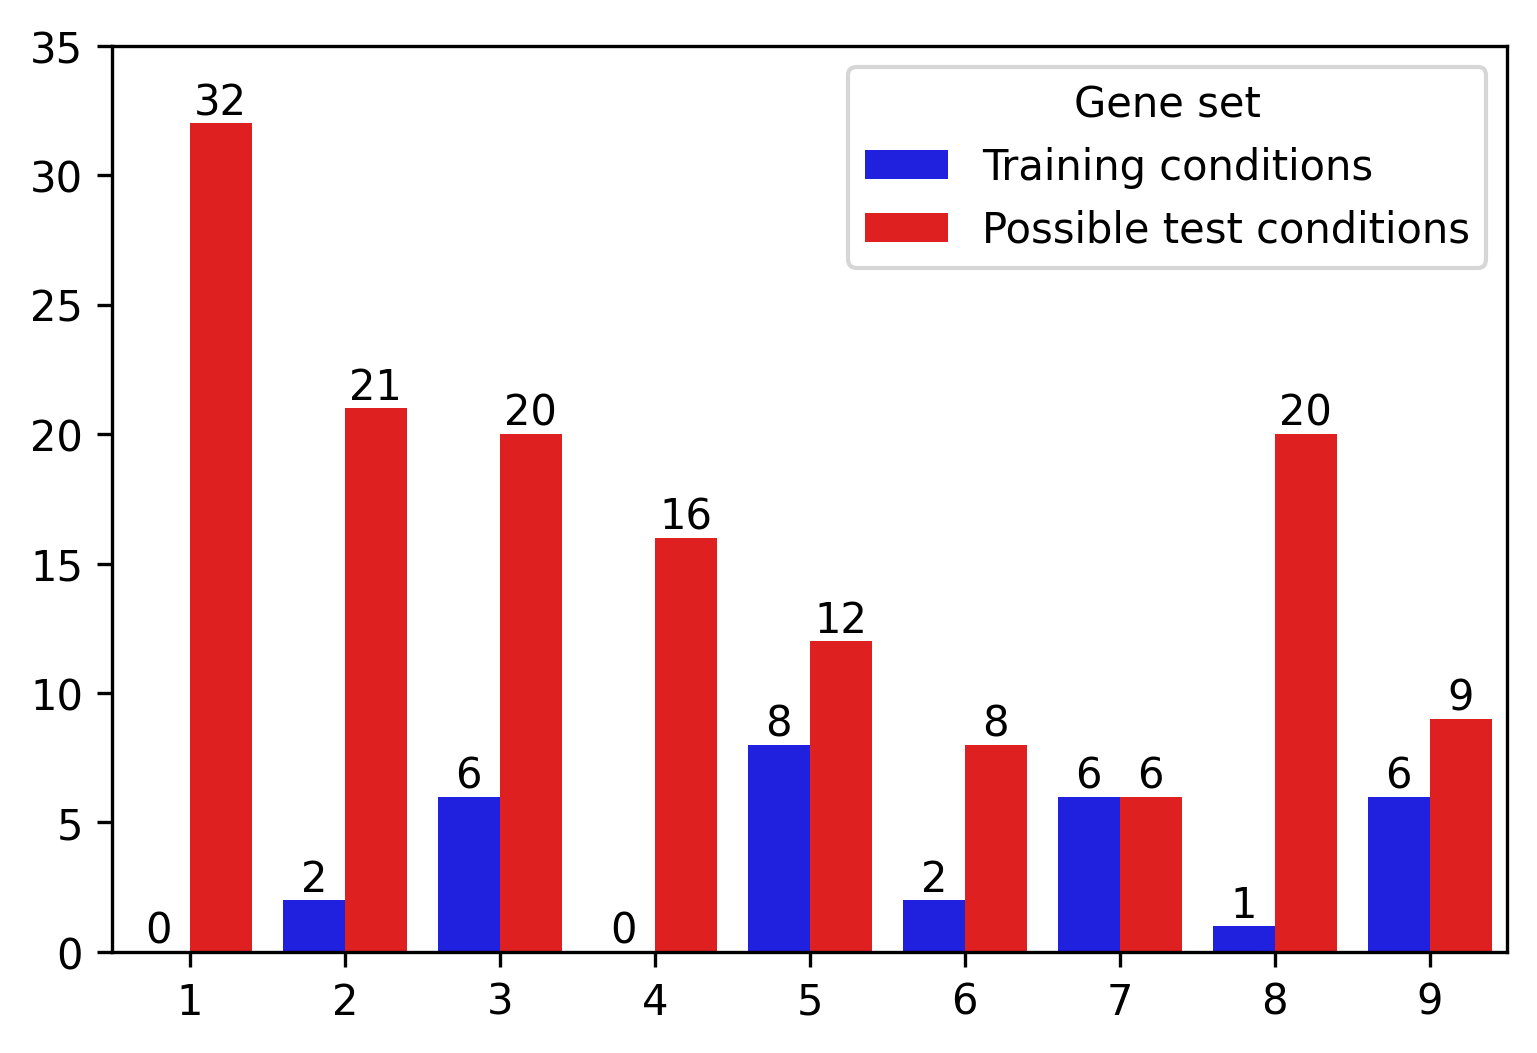

In [35]:
cluster_occ = {"cluster": [], "geneset": [], "n_gs_genes": [], "n_genes": []}
for cluster in np.unique(regulatory_emb_clusters):
    cluster_genes = set(
        regulatory_emb_clusters.loc[regulatory_emb_clusters == cluster].index
    )
    for geneset in ["Training conditions", "Possible test conditions"]:
        if geneset == "Training conditions":
            gs_genes = set(train_targets)
        elif geneset == "Possible test conditions":
            gs_genes = set(test_targets)
        cluster_occ["cluster"].append(cluster)
        cluster_occ["n_gs_genes"].append(len(gs_genes.intersection(cluster_genes)))
        cluster_occ["n_genes"].append(len(cluster_genes))
        cluster_occ["geneset"].append(geneset)

cluster_occ = pd.DataFrame(cluster_occ)
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.barplot(
    data=cluster_occ, x="cluster", y="n_gs_genes", hue="geneset", palette=["b", "r"]
)
# ax.set_xlabel("Regulatory gene embedding cluster")
# ax.set_ylabel("Number of genes")
# ax.set_title(
#     "Number of genes in the training/test set contained \nin the different regulatory gene clusters"
# )
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(title="Gene set")
for i in ax.containers:
    ax.bar_label(
        i,
    )
ax.set_ylim([0, 35])

In [36]:
cluster_occ

,cluster,geneset,n_gs_genes,n_genes
0,1,Training conditions,0,46
1,1,Possible test conditions,32,46
2,2,Training conditions,2,44
3,2,Possible test conditions,21,44
4,3,Training conditions,6,32
5,3,Possible test conditions,20,32
6,4,Training conditions,0,19
7,4,Possible test conditions,16,19
8,5,Training conditions,8,29
9,5,Possible test conditions,12,29


In [37]:
train_test_ratios = []
for cluster in np.unique(cluster_occ.cluster):
    entry = cluster_occ.loc[cluster_occ.cluster == cluster]
    n_train_samples = entry.loc[entry.geneset == "Training conditions", "n_gs_genes"]
    n_test_samples = entry.loc[
        entry.geneset == "Possible test conditions", "n_gs_genes"
    ]
    cluster_occ.loc[entry.index, "train_test_ratio"] = int(n_train_samples) / int(
        n_test_samples
    )

In [38]:
cluster_ratios = cluster_occ.loc[
    cluster_occ.geneset == "Possible test conditions"
].sort_values("train_test_ratio")
cluster_ratios

,cluster,geneset,n_gs_genes,n_genes,train_test_ratio
1,1,Possible test conditions,32,46,0.000000
7,4,Possible test conditions,16,19,0.000000
15,8,Possible test conditions,20,29,0.050000
3,2,Possible test conditions,21,44,0.095238
11,6,Possible test conditions,8,14,0.250000
5,3,Possible test conditions,20,32,0.300000
9,5,Possible test conditions,12,29,0.666667
17,9,Possible test conditions,9,17,0.666667
13,7,Possible test conditions,6,19,1.000000


In [39]:
drop_clusters = [
    [],
    list(cluster_ratios.loc[cluster_ratios.train_test_ratio == 0, "cluster"]),
]
for _, row in cluster_ratios.loc[cluster_ratios.train_test_ratio != 0].iterrows():
    drop_clusters.append(drop_clusters[-1] + [int(row["cluster"])])

In [40]:
drop_clusters = drop_clusters[:4]
drop_clusters

[[], [1, 4], [1, 4, 8], [1, 4, 8, 2]]

The above plot shows that we have no training samples among the genes in cluster 1 and cluster 4. Additionally, we have only one training sample falling into cluster 8. As a consequence our learned map will likely never predict any gene embedding that is similar to the genes in these clusters. As a consequence we expect our map to not perform well in fact likely worse than expected by random chance on the task of predicting the OE conditions corresponding to gene targets falling into these clusters.

---

## Performance evaluation

Having read in the different candidates for the image-based gene perturbation embedding and the regulatory gene embeddings, we will now assess the translation performance.

To this end, we will run an extensive parameter gridsearch to identify for each candiate of gene perturbation embedding the optimal parameters and input freatures for the NTK map. The parameters over which we gridsearch are given below.

In [41]:
model_type = "ntk"
model_params_dicts = [
    {"reg": 0},
    {"reg": 1},
    {"reg": 5},
    {"reg": 10},
    {"reg": 50},
]


use_y_train_mean_params = [True, False]
use_y_mean_params = [False]
n_neighbors_weights_features_params = [0, 10, 31]
n_weight_encodings_params = [2, 5, 10, 20]
append_neighbor_embs_params = [None, "images", "genes"]
neighbor_weight_encoding_params = ["positional", "gauss"]
rff_sigma_params = [1, 5, 10]
normalize_prediction_params = [True, False]
normalize_inputs_params = [True, False]

---

### Mean embeddings and profiles

We start off with using the morphological profiles respectively the image embeddings obtained by averaging all samples from a given overexpression condition, i.e. across nuclei, images and batches. As a consequence we obtain one gene perturbation embedding per OE condition.

In [42]:
use_batch_labels_params = [False]

---

#### Morphological profiles

First, we will assess the performance of the matching using the morphological profiles.

In [43]:
pert_embs = embedding_dict["mean_jump_morph_profiles"]

In [44]:
m_morph_gs_save_file = "../../../data/experiments/jump/translation/gridsearch/ntk_gs_final_eucl_mean/mean_morph.h5"

In [45]:
m_morph_gs_data = run_jump_gridsearch_knn_hits(
    pert_embs=pert_embs._get_numeric_data(),
    reg_embs=regulatory_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    use_y_mean_params=use_y_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    rff_sigma_params=rff_sigma_params,
    normalize_prediction_params=normalize_prediction_params,
    normalize_inputs_params=normalize_inputs_params,
    use_batch_labels_params=use_batch_labels_params,
    batch_labels=None,
    save_output_file=m_morph_gs_save_file,
)

  0%|          | 0/7680 [00:00<?, ?it/s]

<ipython-input-18-3a3273de9804>:75: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_hit_results.to_hdf(save_output_file, key="data", index=False)


In [46]:
m_morph_gs_data = pd.read_hdf(m_morph_gs_save_file)

The output contains for each parameter configuration for each OE condition in the test set how far in terms of kNN distance the prediction is from the true regulatory embedding. Using these information, we will compute the kNN accuracy of the for each configuration.

In [47]:
m_morph_gs_knn_accs = get_cluster_knn_accs_for_config_ids(
    m_morph_gs_data,
    regulatory_emb_clusters,
    drop_clusters=drop_clusters,
)
m_morph_gs_knn_accs = add_cluster_aucs_for_knn_acc_results(m_morph_gs_knn_accs)

  0%|          | 0/7680 [00:00<?, ?it/s]

  0%|          | 0/7680 [00:00<?, ?it/s]

In [48]:
m_morph_knn_file = os.path.join(
    os.path.split(m_morph_gs_save_file)[0], "mean_morph_knn_accs.h5"
)

In [49]:
m_morph_gs_knn_accs.to_hdf(
    m_morph_knn_file,
    key="data",
    index=False,
)

<ipython-input-49-c7814e633f1c>:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cluster', 'genes', 'knn_hits'], dtype='object')]

  m_morph_gs_knn_accs.to_hdf(


In [50]:
m_morph_gs_knn_accs = pd.read_hdf(m_morph_knn_file)

The kNN accuracy was computed for each gene cluster that we had previously identified using the regulatory gene embeddings individually as well as jointly. As seen above there are two clusters that do not contain any genes targeted in the training conditions. Here, we assess the performances only on the genes that fall into any cluster that contains at least one gene targeted in the training condition. This is because the NTK has no chance to generalize well to these conditions as their targets are outside the span of the training samples.

In [51]:
cc_m_morph_gs_knn_accs = m_morph_gs_knn_accs.loc[
    m_morph_gs_knn_accs.cluster == "1_4_8"
].copy()

To identify the optimal configuration, we look at the sum of the area under the kNN accuracy curve for k in [10,20,30,40,50] and select the configuration that maximizes that score.

In [52]:
cc_m_morph_gs_knn_accs.groupby("config_id").mean(numeric_only=True).loc[
    :, ["10nn_auc", "20nn_auc", "30nn_auc", "40nn_auc", "50nn_auc"]
].sum(axis=1).sort_values(ascending=False).head(1)

config_id
1412    0.493487
dtype: float64

We find that the model with the configuration 638 achieves the maximum of this score and thus we select it at as the final solution of our NTK map predicting unseen gene perturbations using the morphological profiles as input information.

In [55]:
m_morph_best_knn_acc_results = cc_m_morph_gs_knn_accs.loc[
    cc_m_morph_gs_knn_accs.config_id == 1412
]

The output below characterizes the optimal model configuration.

In [56]:
m_morph_gs_data.loc[m_morph_gs_data.config_id == 1412].head(1).iloc[:, 2:-1]

,reg,use_mean_train_reg_embs,use_mean_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,use_batch_labels,normalize_inputs,normalize_prediction,config_id
VCAN,0,False,False,31,10,gauss,None,10,False,True,True,1412


---

#### Image-embeddings

We perform the same line of experiments and analyses using the image embeddings as input.

In [57]:
pert_embs = embedding_dict["mean_jump_img_embs"]

In [58]:
m_img_embs_save_file = "../../../data/experiments/jump/translation/gridsearch/ntk_gs_final_eucl_mean/mean_img_embs.h5"

In [76]:
m_img_embs_gs_data = run_jump_gridsearch_knn_hits(
    pert_embs=pert_embs._get_numeric_data(),
    reg_embs=regulatory_embs,
    train_targets=list(train_targets),
    test_targets=list(test_targets),
    model_type=model_type,
    model_params_dicts=model_params_dicts,
    use_y_train_mean_params=use_y_train_mean_params,
    use_y_mean_params=use_y_mean_params,
    n_neighbors_weights_features_params=n_neighbors_weights_features_params,
    n_weight_encodings_params=n_weight_encodings_params,
    append_neighbor_embs_params=append_neighbor_embs_params,
    neighbor_weight_encoding_params=neighbor_weight_encoding_params,
    normalize_prediction_params=normalize_prediction_params,
    normalize_inputs_params=normalize_inputs_params,
    rff_sigma_params=rff_sigma_params,
    use_batch_labels_params=use_batch_labels_params,
    batch_labels=None,
    save_output_file=m_img_embs_save_file,
)

  0%|          | 0/7680 [00:00<?, ?it/s]

<ipython-input-18-3a3273de9804>:75: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['model', 'pos_encoding_type', 'append_neighbor_embs'], dtype='object')]

  all_knn_hit_results.to_hdf(save_output_file, key="data", index=False)


In [77]:
m_img_embs_gs_data = pd.read_hdf(m_img_embs_save_file)

Again we compute the kNN accuracy performance.

In [78]:
m_img_gs_knn_accs = get_cluster_knn_accs_for_config_ids(
    m_img_embs_gs_data,
    regulatory_emb_clusters,
    drop_clusters=drop_clusters,
)
m_img_gs_knn_accs = add_cluster_aucs_for_knn_acc_results(m_img_gs_knn_accs)

  0%|          | 0/7680 [00:00<?, ?it/s]

  0%|          | 0/7680 [00:00<?, ?it/s]

In [79]:
m_img_knn_file = os.path.join(
    os.path.split(m_img_embs_save_file)[0], "mean_img_embs_knn_accs.h5"
)

In [80]:
m_img_gs_knn_accs.to_hdf(
    m_img_knn_file,
    key="data",
    index=False,
)

<ipython-input-80-bdd4d325bf63>:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cluster', 'genes', 'knn_hits'], dtype='object')]

  m_img_gs_knn_accs.to_hdf(


In [81]:
m_img_gs_knn_accs = pd.read_hdf(m_img_knn_file)

In [83]:
cc_m_img_gs_knn_accs = m_img_gs_knn_accs.loc[
    m_img_gs_knn_accs.cluster == "1_4_8"
].copy()

We again identify the configuration that performs best for the test conditions in which a gene was target that fell into a cluster of at least one training condition.

In [84]:
cc_m_img_gs_knn_accs.groupby("config_id").mean(numeric_only=True).loc[
    :, ["10nn_auc", "20nn_auc", "30nn_auc", "40nn_auc", "50nn_auc"]
].sum(axis=1).sort_values(ascending=False).head(1)

config_id
4558    0.584978
dtype: float64

We find the best model for configuration with ID 5318.

In [85]:
m_img_best_knn_acc_results = cc_m_img_gs_knn_accs.loc[
    cc_m_img_gs_knn_accs.config_id == 4558
]

The respective configuration is shown below.

In [86]:
m_img_embs_gs_data.loc[m_img_embs_gs_data.config_id == 4558].head(1).iloc[:, 2:-1]

,reg,use_mean_train_reg_embs,use_mean_reg_embs,n_neighbors_pos_encodings,n_pos_encodings,pos_encoding_type,append_neighbor_embs,rff_sigma,use_batch_labels,normalize_inputs,normalize_prediction,config_id
VCAN,5,False,False,31,20,gauss,None,10,False,True,False,4558


---

### Baselines

As for our analyses using the dataset from Rohban et al, we will compare the performance against two baselines. First a random baseline that just randomly predicts any of the genes to be targeted in the test OE condition, a mean baseline that will predict the mean of all regulatory embeddings. The baselines are further described in the paper. Note that the number of test samples differs depending on whether or not we aggregated the data by condition or by bach and condition, we will compute the mean baseline for these two settings. The random baseline is not affected by these changes.

#### Random baseline

In [87]:
pert_embs = embedding_dict["mean_jump_img_embs"]

In [88]:
all_random_knn_hit_data = []
for b in tqdm(range(100)):
    random_knn_hit_data = get_jump_knn_hit_data(
        get_jump_random_nn_prediction_dict(
            pert_embs, regulatory_embs, train_targets, test_targets, random_state=1234
        ),
    )
    random_knn_hit_data["config_id"] = b
    all_random_knn_hit_data.append(random_knn_hit_data)
all_random_knn_hit_data = pd.concat(all_random_knn_hit_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [89]:
random_baseline_knn_accs = get_cluster_knn_accs_for_config_ids(
    all_random_knn_hit_data,
    regulatory_emb_clusters,
    drop_clusters=drop_clusters,
)
random_baseline_knn_accs = add_cluster_aucs_for_knn_acc_results(
    random_baseline_knn_accs
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [90]:
cc_random_baseline_knn_accs = random_baseline_knn_accs.loc[
    random_baseline_knn_accs.cluster == "1_4_8"
]

---

#### Mean baseline

In [91]:
pert_embs = embedding_dict["mean_jump_img_embs"]

In [92]:
mean_knn_hit_data = get_jump_knn_hit_data(
    get_jump_nn_prediction_dict(
        pert_embs,
        regulatory_embs,
        list(train_targets),
        list(test_targets),
        model_type="mean_all",
    )
)
mean_knn_hit_data["config_id"] = 0

In [93]:
mean_baseline_knn_accs = get_cluster_knn_accs_for_config_ids(
    mean_knn_hit_data,
    regulatory_emb_clusters,
    drop_clusters=drop_clusters,
)
mean_baseline_knn_accs = add_cluster_aucs_for_knn_acc_results(mean_baseline_knn_accs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [94]:
cc_mean_baseline_knn_accs = mean_baseline_knn_accs.loc[
    mean_baseline_knn_accs.cluster == "1_4_8"
]

In [95]:
cc_mean_baseline_knn_accs.groupby("config_id").mean(numeric_only=True).loc[
    :, ["10nn_auc", "20nn_auc", "30nn_auc", "40nn_auc", "50nn_auc"]
].sum(axis=1).sort_values(ascending=False).head(1)

config_id
0    0.490943
dtype: float64

#### Train-Mean baseline

In [96]:
pert_embs = embedding_dict["mean_jump_img_embs"]

In [97]:
train_mean_knn_hit_data = get_jump_knn_hit_data(
    get_jump_nn_prediction_dict(
        pert_embs._get_numeric_data(),
        regulatory_embs,
        list(train_targets),
        list(test_targets),
        model_type="mean",
    )
)
train_mean_knn_hit_data["config_id"] = 0

In [98]:
train_mean_baseline_knn_accs = get_cluster_knn_accs_for_config_ids(
    train_mean_knn_hit_data,
    regulatory_emb_clusters,
    drop_clusters=drop_clusters,
)
train_mean_baseline_knn_accs = add_cluster_aucs_for_knn_acc_results(
    train_mean_baseline_knn_accs
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [99]:
cc_train_mean_baseline_knn_accs = train_mean_baseline_knn_accs.loc[
    train_mean_baseline_knn_accs.cluster == "1_4_8"
]

In [100]:
cc_train_mean_baseline_knn_accs.groupby("config_id").mean(numeric_only=True).loc[
    :, ["10nn_auc", "20nn_auc", "30nn_auc", "40nn_auc", "50nn_auc"]
].sum(axis=1).sort_values(ascending=False).head(1)

config_id
0    0.461974
dtype: float64

---

## Performance summary

In [101]:
m_morph_best_knn_acc_results["Model"] = "Morphological Profiles"
m_img_best_knn_acc_results["Model"] = "Image2Reg"


all_knn_results = pd.concat([m_morph_best_knn_acc_results, m_img_best_knn_acc_results])


<ipython-input-101-d65d3a9c8fc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_morph_best_knn_acc_results["Model"] = "Morphological Profiles"
<ipython-input-101-d65d3a9c8fc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_img_best_knn_acc_results["Model"] = "Image2Reg"


Text(0, 0.5, '')

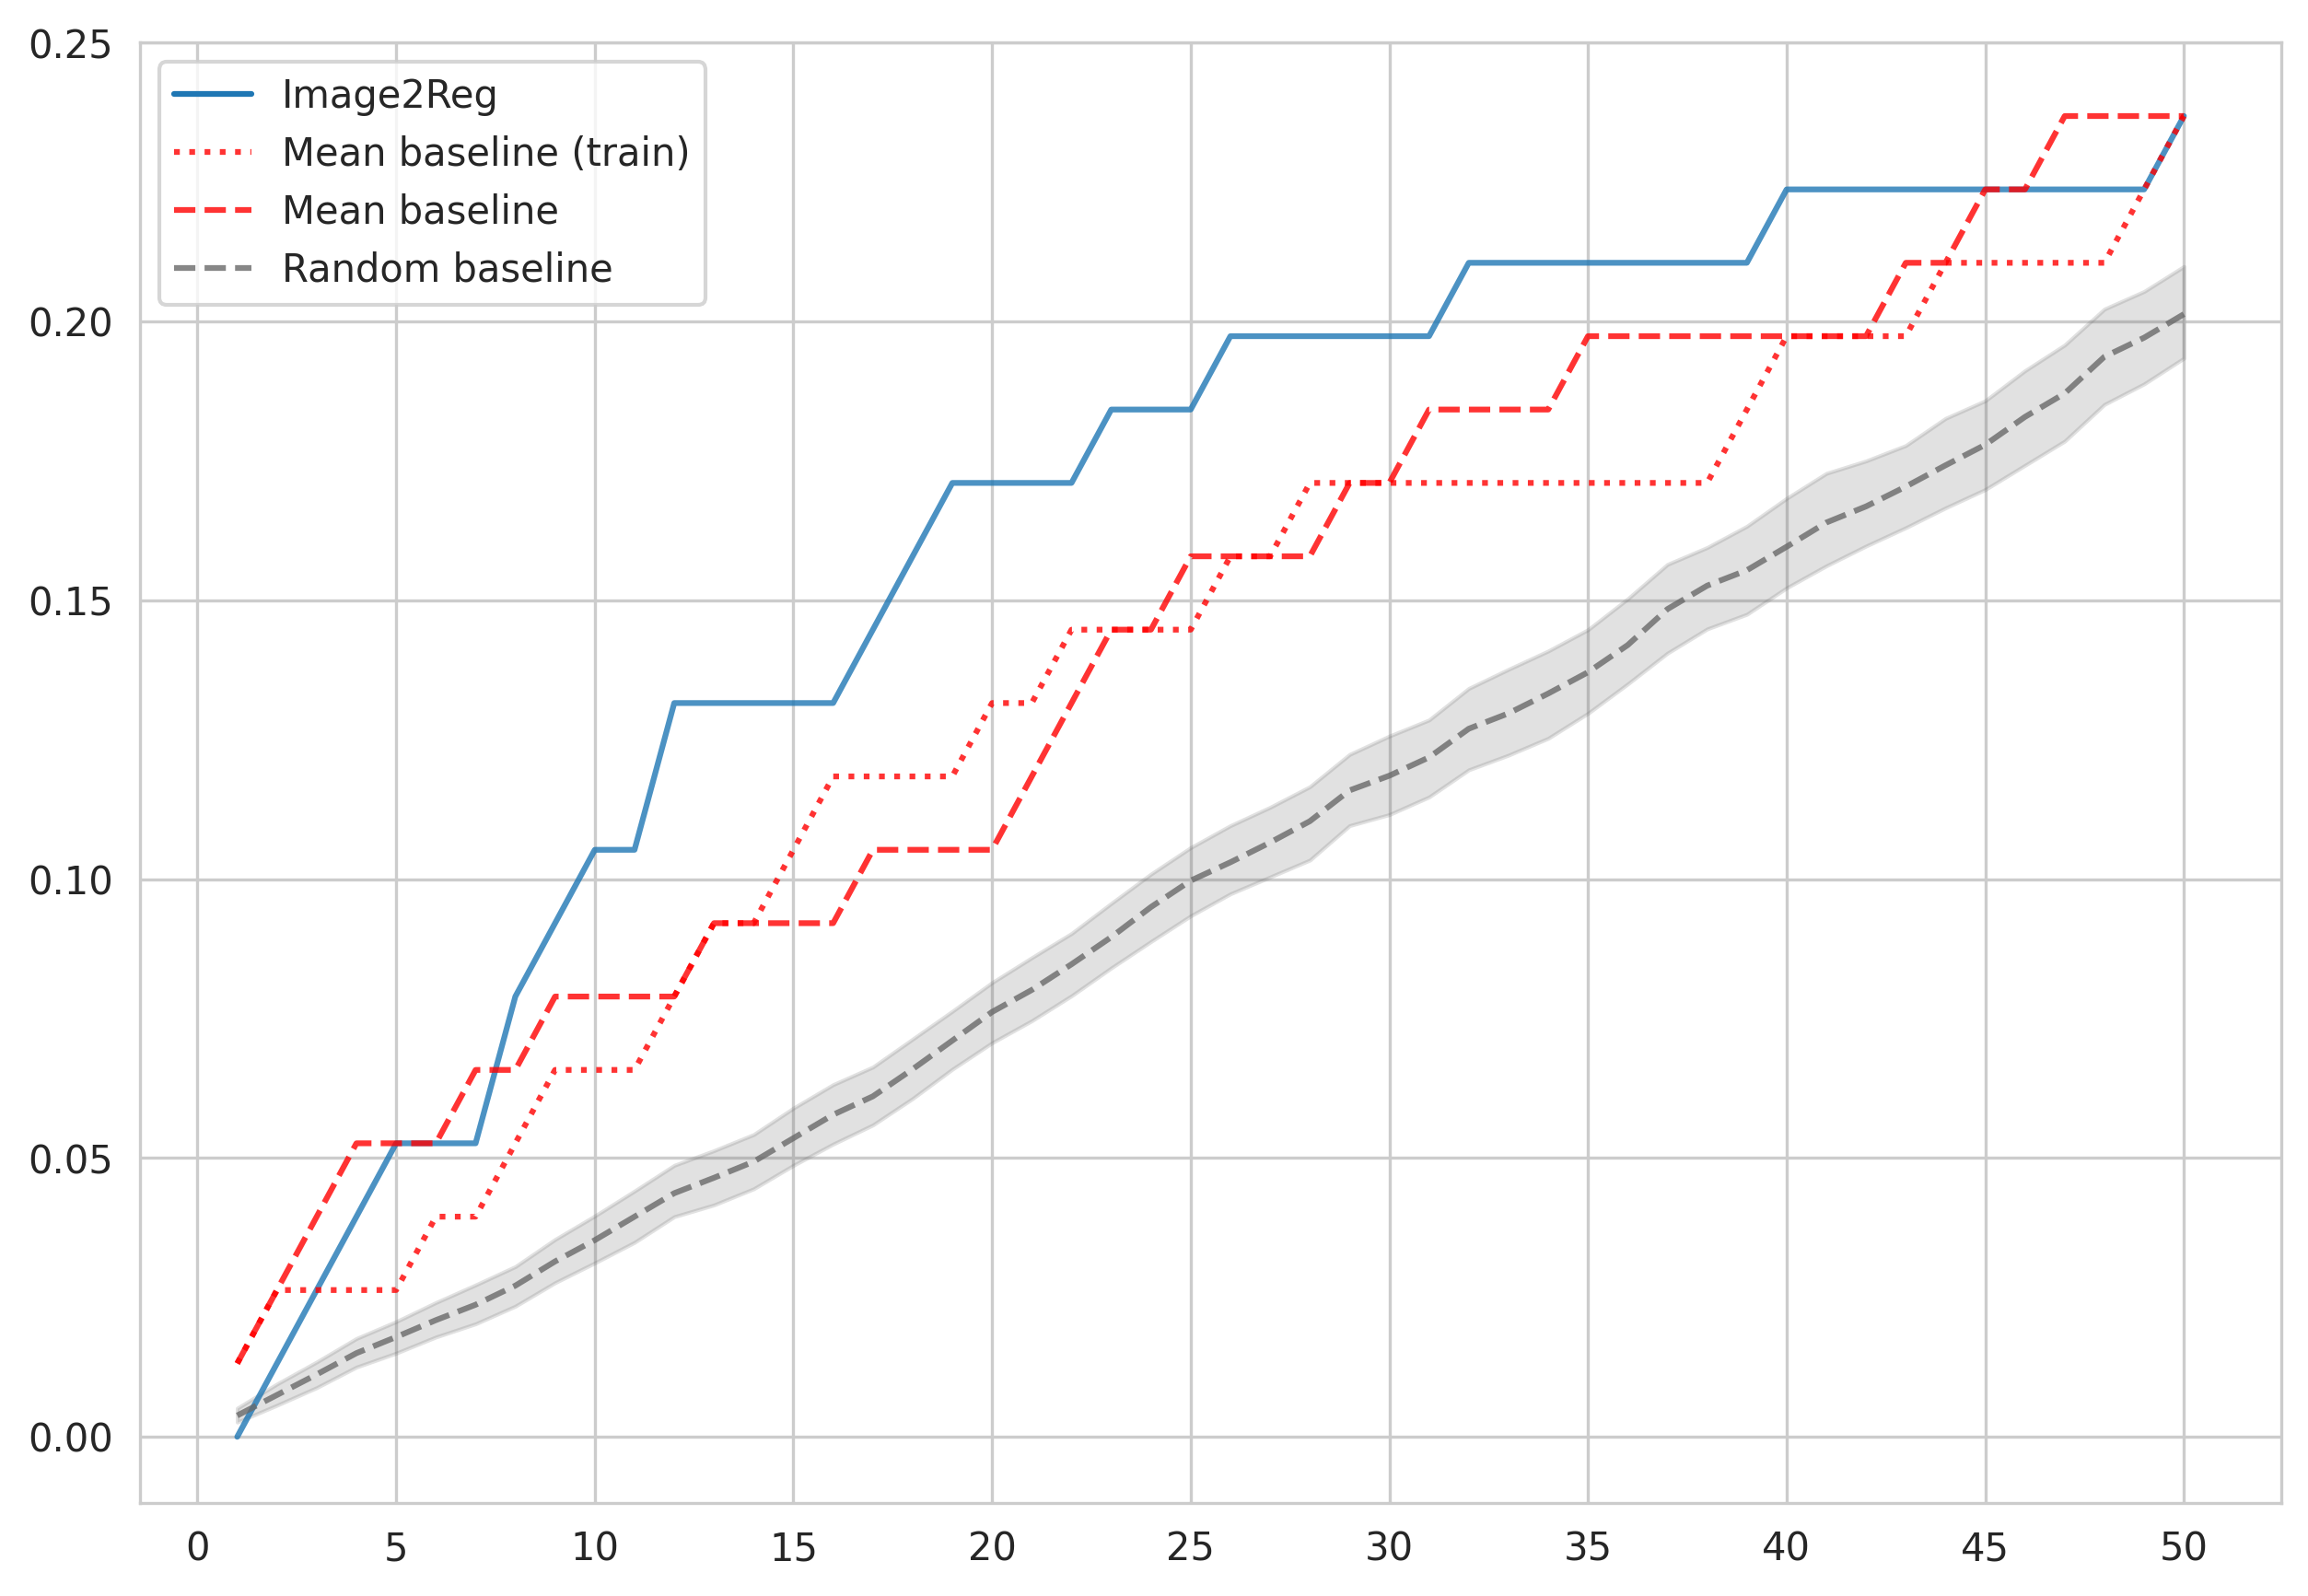

In [102]:
fig, ax = plot_translation_performance(
    all_knn_results.loc[all_knn_results.loc[:, "Model"] == "Image2Reg"],
    hue="Model",
    ymax=0.3,
    title="",
    random_baseline=cc_random_baseline_knn_accs,
    mean_baseline=cc_mean_baseline_knn_accs,
    mean_train_baseline=cc_train_mean_baseline_knn_accs,
    figsize=[10, 7],
    cmap=None,
    style=None,
    style_order=None,
    param_title=None,
    legend_title="",
    alpha=0.8,
)
# ax.set_title("Performance for mean embeddings/profiles")
# ax.set_ylabel("kNN accuracy")
# ax.set_xlabel("k nearest neighbors")
ax.set_xlabel("")
ax.set_ylabel("")

---

## Visualization of the predictions